In [1]:
##############################################################
##https://github.com/shalomma/PytorchBottleneck/tree/master###
##############################################################
##Tanh激活函数的全连接网络 784*1024*1024*20*20*20*10
import torch

class FeedForward(torch.nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FeedForward, self).__init__()
        torch.manual_seed(1234)
        self.hidden_sizes = hidden_sizes
        self.layers = torch.nn.ModuleList()
        hidden_sizes += [output_size]
        self.n_layers = len(hidden_sizes)
        prev = input_size
        for h in hidden_sizes:
            self.layers.append(torch.nn.Linear(prev, h))
            prev = h

    def forward(self, x):
        hiddens = []
        for j, layer in enumerate(self.layers):
            if j != (self.n_layers - 1):
                x = torch.tanh(layer(x))
                hiddens.append(x)
            else:
                x = layer(x)
                hiddens.append(x)
        return x, hiddens

In [2]:
import torch
from torch.utils import data
from torchvision import datasets
import scipy.io as sio

##########################################################################
class MNIST(datasets.MNIST):
    def __init__(self, root, train=True, download=False, randomize=False):
        super(MNIST, self).__init__(root, train, download)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.targets = self.targets.to(device)
        self.data = self.data / 255.0
        self.data = self.data.view(-1, 28 * 28).to(device)

        if randomize:
            idx_rnd = torch.randperm(len(self.targets))
            self.targets = self.targets[idx_rnd]

    def __getitem__(self, index):
        img, targets = self.data[index], self.targets[index]
        return img, targets
######################################################################

class IBDataset(data.Dataset):
    def __init__(self, train=True, ratio=0.8):
        super(IBDataset, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        data_, targets_ = self.load_data(train, ratio)

        self.targets = targets_.to(device)
        self.target = targets_.to(device)
        self.data = data_.to(device)

    @staticmethod
    def load_data(train, ratio):
        d = sio.loadmat('D:/深度学习与信息论/PytorchBottleneck-master\dataset/var_u.mat')
        x = d['F']
        y = d['y'][0]

        r = ratio if train else (1 - ratio)
        n = int(r * len(x))
        if train:
            x = x[:n, :]
            y = y[:n]
        else:
            x = x[-n:, :]
            y = y[-n:]
        return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample, target = self.data[index], self.target[index]
        return sample, target

In [3]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from random import seed

from dataset import MNIST

In [4]:
import numpy as np


def get_unique_probs(x):
    uniqueids = np.ascontiguousarray(x).view(np.dtype((np.void, x.dtype.itemsize * x.shape[1])))
    _, unique_inverse, unique_counts = np.unique(uniqueids, return_index=False, return_inverse=True, return_counts=True)
    return np.asarray(unique_counts / float(sum(unique_counts))), unique_inverse


def bin_calc_information(labelixs, layerdata, binsize):
    # This is even further simplified, where we use np.floor instead of digitize
    nats2bits = 1.0 / np.log(2)

    def get_h(d):
        digitized = np.floor(d / binsize).astype('int')
        p_ts, _ = get_unique_probs( digitized )
        return -np.sum(p_ts * np.log(p_ts))

    H_LAYER = get_h(layerdata)
    H_LAYER_GIVEN_OUTPUT = 0
    for label, ixs in labelixs.items():
        h = get_h(layerdata[ixs])
        H_LAYER_GIVEN_OUTPUT += ixs.mean() * h
    return nats2bits * H_LAYER, nats2bits * (H_LAYER - H_LAYER_GIVEN_OUTPUT)

In [11]:
import pickle
class TrainConfig:
    def __init__(self, model, criterion, optimizer, scheduler=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler


class Train:
    def __init__(self, config):
        self.config = config
        self.epochs = 5000
        self.mi_cycle = 10
        self.n_layers = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.losses = dict()
        self.accuracy = dict()
        self.running_mis_xt = dict()
        self.running_mis_ty = dict()
        for phase in ['train', 'test']:
            self.losses[phase] = []
            self.accuracy[phase] = []
            self.running_mis_xt[phase] = []
            self.running_mis_ty[phase] = []

        self.n_classes = 10

    def get_class_masks(self, loader):
        samples_split = dict()
        for phase in ['train', 'test']:
            samples_split[phase] = {}
            classes = loader[phase].dataset.targets.cpu().detach().numpy()
            for i in range(self.n_classes):
                samples_split[phase][i] = classes == i
        return samples_split

    def run(self, loader):
        class_masks = self.get_class_masks(loader)
        self.n_layers = self.config.model.n_layers
        for i in range(self.epochs):
            to_print = ''
            for phase in ['train', 'test']:
                phase_loss = 0.0
                phase_labels = torch.tensor([], dtype=torch.long).to(self.device)
                phase_outputs = torch.tensor([]).to(self.device)

                for inputs, labels in loader[phase]:
                    inputs, labels = inputs, labels
                    if phase == 'train':
                        self.config.model.train()
                    else:
                        self.config.model.eval()

                    self.config.optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs, hiddens = self.config.model(inputs)
                        loss = self.config.criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            self.config.optimizer.step()

                    phase_loss += loss.item()
                    phase_labels = torch.cat((phase_labels, labels))
                    phase_outputs = torch.cat((phase_outputs, outputs))

                if i % self.mi_cycle == 0:
                    running_mi_xt = []
                    running_mi_ty = []
                    _, hiddens = self.config.model(loader[phase].dataset.data)
                    for j in range(self.n_layers):
                        activity = hiddens[j].cpu().detach().numpy()
                        binxm, binym = bin_calc_information(class_masks[phase], activity, binsize=0.5)
                        running_mi_xt.append(binxm)
                        running_mi_ty.append(binym)

                    self.running_mis_xt[phase].append(running_mi_xt)
                    self.running_mis_ty[phase].append(running_mi_ty)

                n = float(len(loader[phase].dataset))
                loss = phase_loss / n
                acc = (phase_labels == phase_outputs.argmax(dim=1)).sum() / n
                self.accuracy[phase].append(float(acc))

                to_print += f'{phase}: loss {loss:>.4f} - acc {acc:>.4f} \t'
                self.losses[phase].append(loss)
                if phase == 'test':
                    if self.config.scheduler is not None:
                        self.config.scheduler.step(loss)
            print(f'Epoch {i:>4}: {to_print}')

    def dump(self):
        tracking = {
            'n_layers': self.n_layers,
            'mi_cycle': self.mi_cycle,
            'losses': self.losses,
            'accuracy': self.accuracy,
            'running_mis_xt': self.running_mis_xt,
            'running_mis_ty': self.running_mis_ty,
        }
        with open('train.pkl', 'wb') as f:
            pickle.dump(tracking, f)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
#import scienceplots
class Plotter:
    def __init__(self, trainer):
        self.trainer = trainer

    def plot_losses(self):
        plt.figure()
        for phase in ['train', 'test']:
            plt.plot(self.trainer.losses[phase], label=phase)
        plt.legend()
        plt.savefig('losses.png')
        plt.show()

    def plot_accuracy(self):
        plt.figure()
        for phase in ['train', 'test']:
            plt.plot(self.trainer.accuracy[phase], label=phase)
        plt.legend()
        plt.savefig('acc.png')
        plt.show()

    def format_epochs(self, x, pos):
        return int(x * self.trainer.mi_cycle)

    def plot_info_plan(self, phase):
        running_mis_xt = np.array(self.trainer.running_mis_xt[phase])
        running_mis_ty = np.array(self.trainer.running_mis_ty[phase])
        # plt.rcParams ['font.serif'] = ['Times New Roman']
        # mpl.rcParams['figure.dpi'] = 800
        # mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
        # plt.style.use(['science','ieee'])
        fig, ax = plt.subplots()
        plt.title(phase)
        for i in range(self.trainer.n_layers):
            plt.plot(running_mis_xt[:, i], label=f'{i}')
        plt.legend()
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(self.format_epochs))
        plt.ylabel('I(X;T)')
        plt.savefig(f'plot_{phase}.png')
        plt.show()

        plt.figure()
        plt.title(f'IP - {phase}')
        c = list(range(len(running_mis_xt[:, 0])))
        for j in range(self.trainer.n_layers):
            plt.scatter(running_mis_xt[:, j], running_mis_ty[:, j], c=c, cmap='plasma', s=20, alpha=0.85, zorder=1)
        for j in range(len(running_mis_xt[:, 0])):
            plt.plot(running_mis_xt[j, :], running_mis_ty[j, :], alpha=0.1, zorder=0)

        cbar = plt.colorbar(format=ticker.FuncFormatter(self.format_epochs))
        cbar.set_label('Epochs')

        plt.xlabel('I(X;T)')
        plt.ylabel('I(T;Y)')
        plt.savefig(f'IP_{phase}.png')
        plt.show()

In [17]:
np.random.seed(1234)
seed(1234)
torch.manual_seed(1234)

In [18]:
data = dict()
data['train'] = MNIST('./dataset', train=True, download=True, randomize=False)
data['test'] = MNIST('./dataset', train=False)

loader = dict()
loader['train'] = torch.utils.data.DataLoader(data['train'], batch_size=60000, shuffle=False)
loader['test'] = torch.utils.data.DataLoader(data['test'], batch_size=10000, shuffle=False)

In [19]:
# setup
input_size = 28 * 28
output_size = 10
hidden_sizes = [784, 1024, 1024, 20, 20, 20, 10]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'to device: {device}')
net = FeedForward(input_size, hidden_sizes, output_size).to(device)

to device: cuda


In [20]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

cfg = TrainConfig(net, criterion, optimizer)
train = Train(cfg)
train.epochs = 400
train.mi_cycle = 20
train.run(loader)
train.dump()

Epoch    0: train: loss 2.3179 - acc 0.0993 	test: loss 2.2832 - acc 0.1294 	
Epoch    1: train: loss 2.2838 - acc 0.1242 	test: loss 2.2377 - acc 0.2969 	
Epoch    2: train: loss 2.2392 - acc 0.2895 	test: loss 2.1996 - acc 0.2991 	
Epoch    3: train: loss 2.2014 - acc 0.2893 	test: loss 2.1750 - acc 0.3242 	
Epoch    4: train: loss 2.1766 - acc 0.3178 	test: loss 2.1557 - acc 0.3801 	
Epoch    5: train: loss 2.1573 - acc 0.3673 	test: loss 2.1417 - acc 0.4266 	
Epoch    6: train: loss 2.1432 - acc 0.4058 	test: loss 2.1290 - acc 0.4294 	
Epoch    7: train: loss 2.1304 - acc 0.4147 	test: loss 2.1173 - acc 0.4340 	
Epoch    8: train: loss 2.1184 - acc 0.4213 	test: loss 2.1065 - acc 0.4460 	
Epoch    9: train: loss 2.1078 - acc 0.4345 	test: loss 2.0946 - acc 0.4487 	
Epoch   10: train: loss 2.0963 - acc 0.4371 	test: loss 2.0840 - acc 0.4577 	
Epoch   11: train: loss 2.0859 - acc 0.4450 	test: loss 2.0737 - acc 0.4697 	
Epoch   12: train: loss 2.0757 - acc 0.4605 	test: loss 2.0629 -

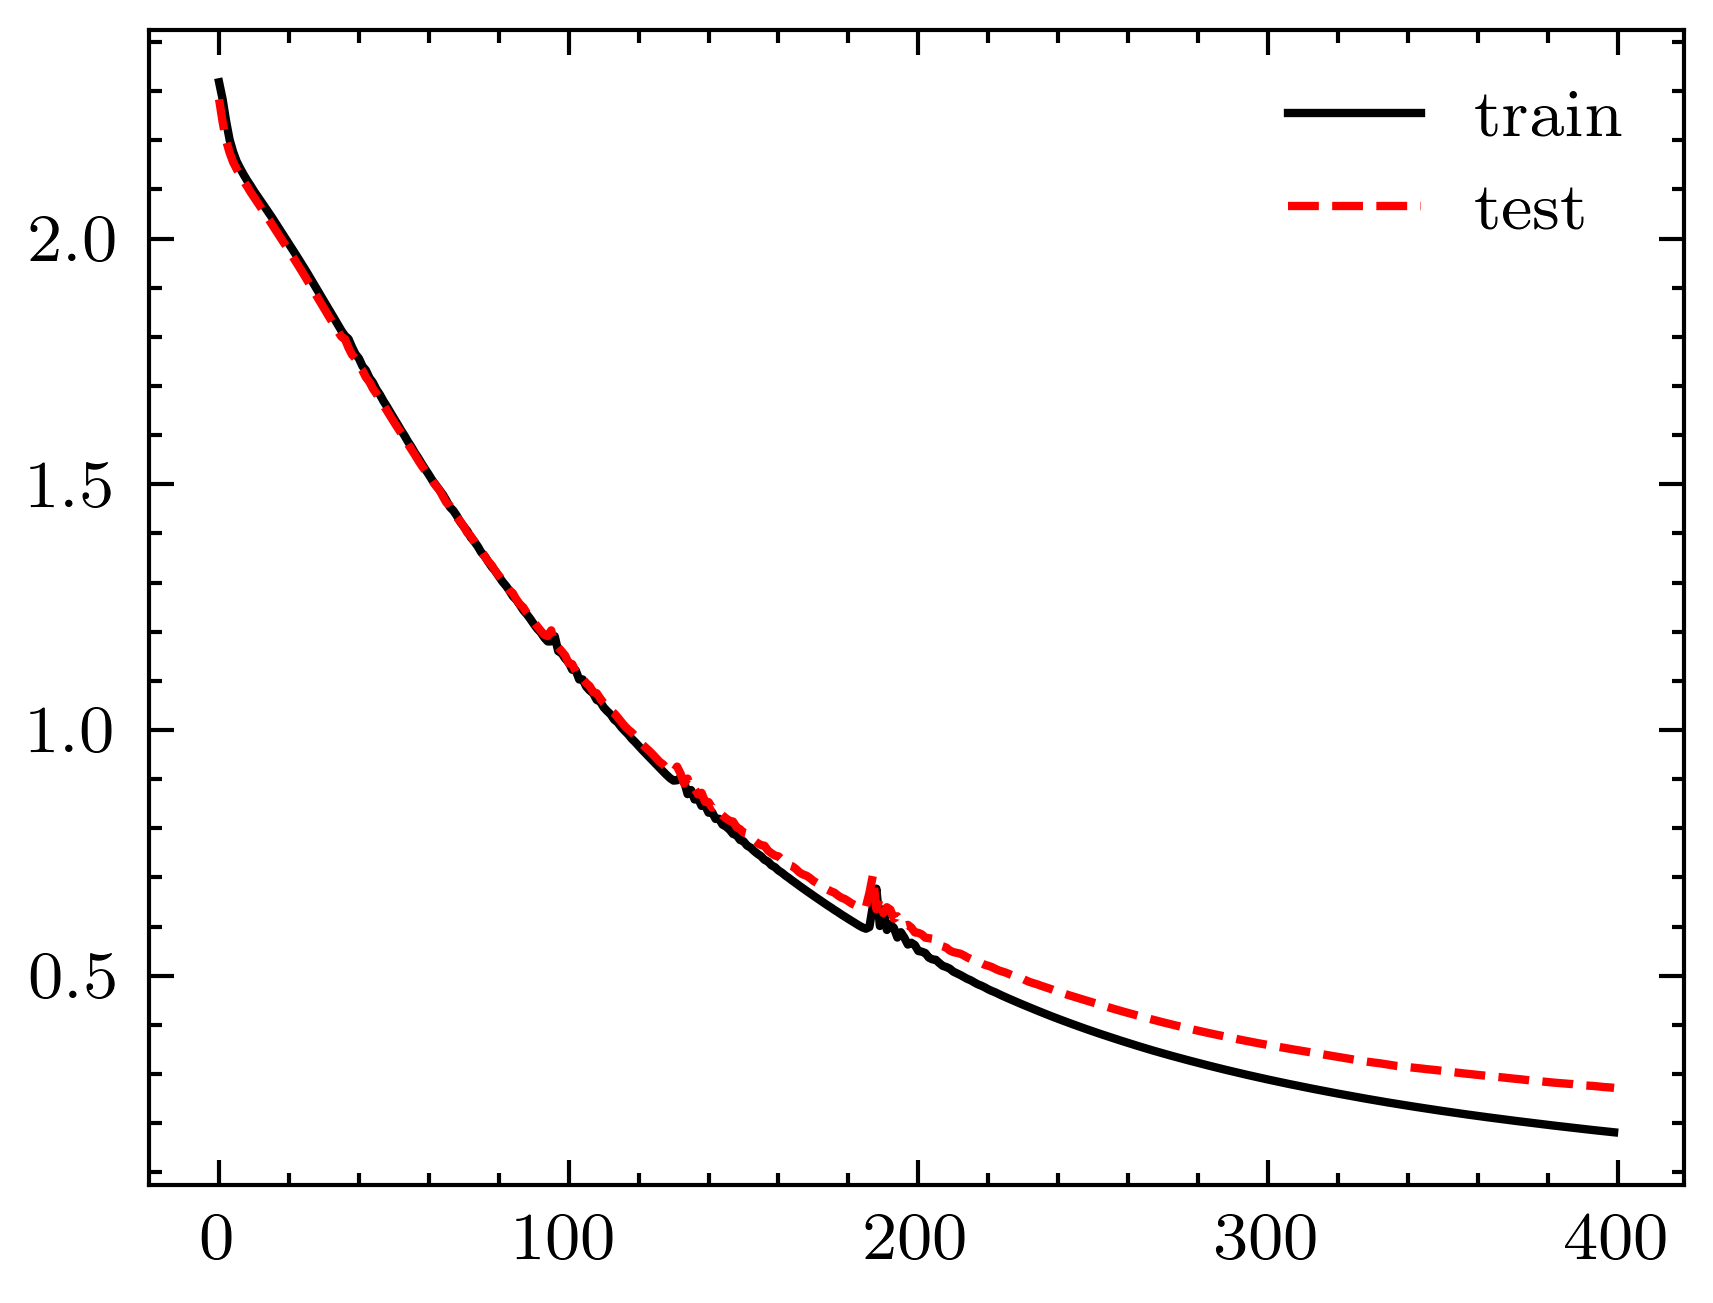

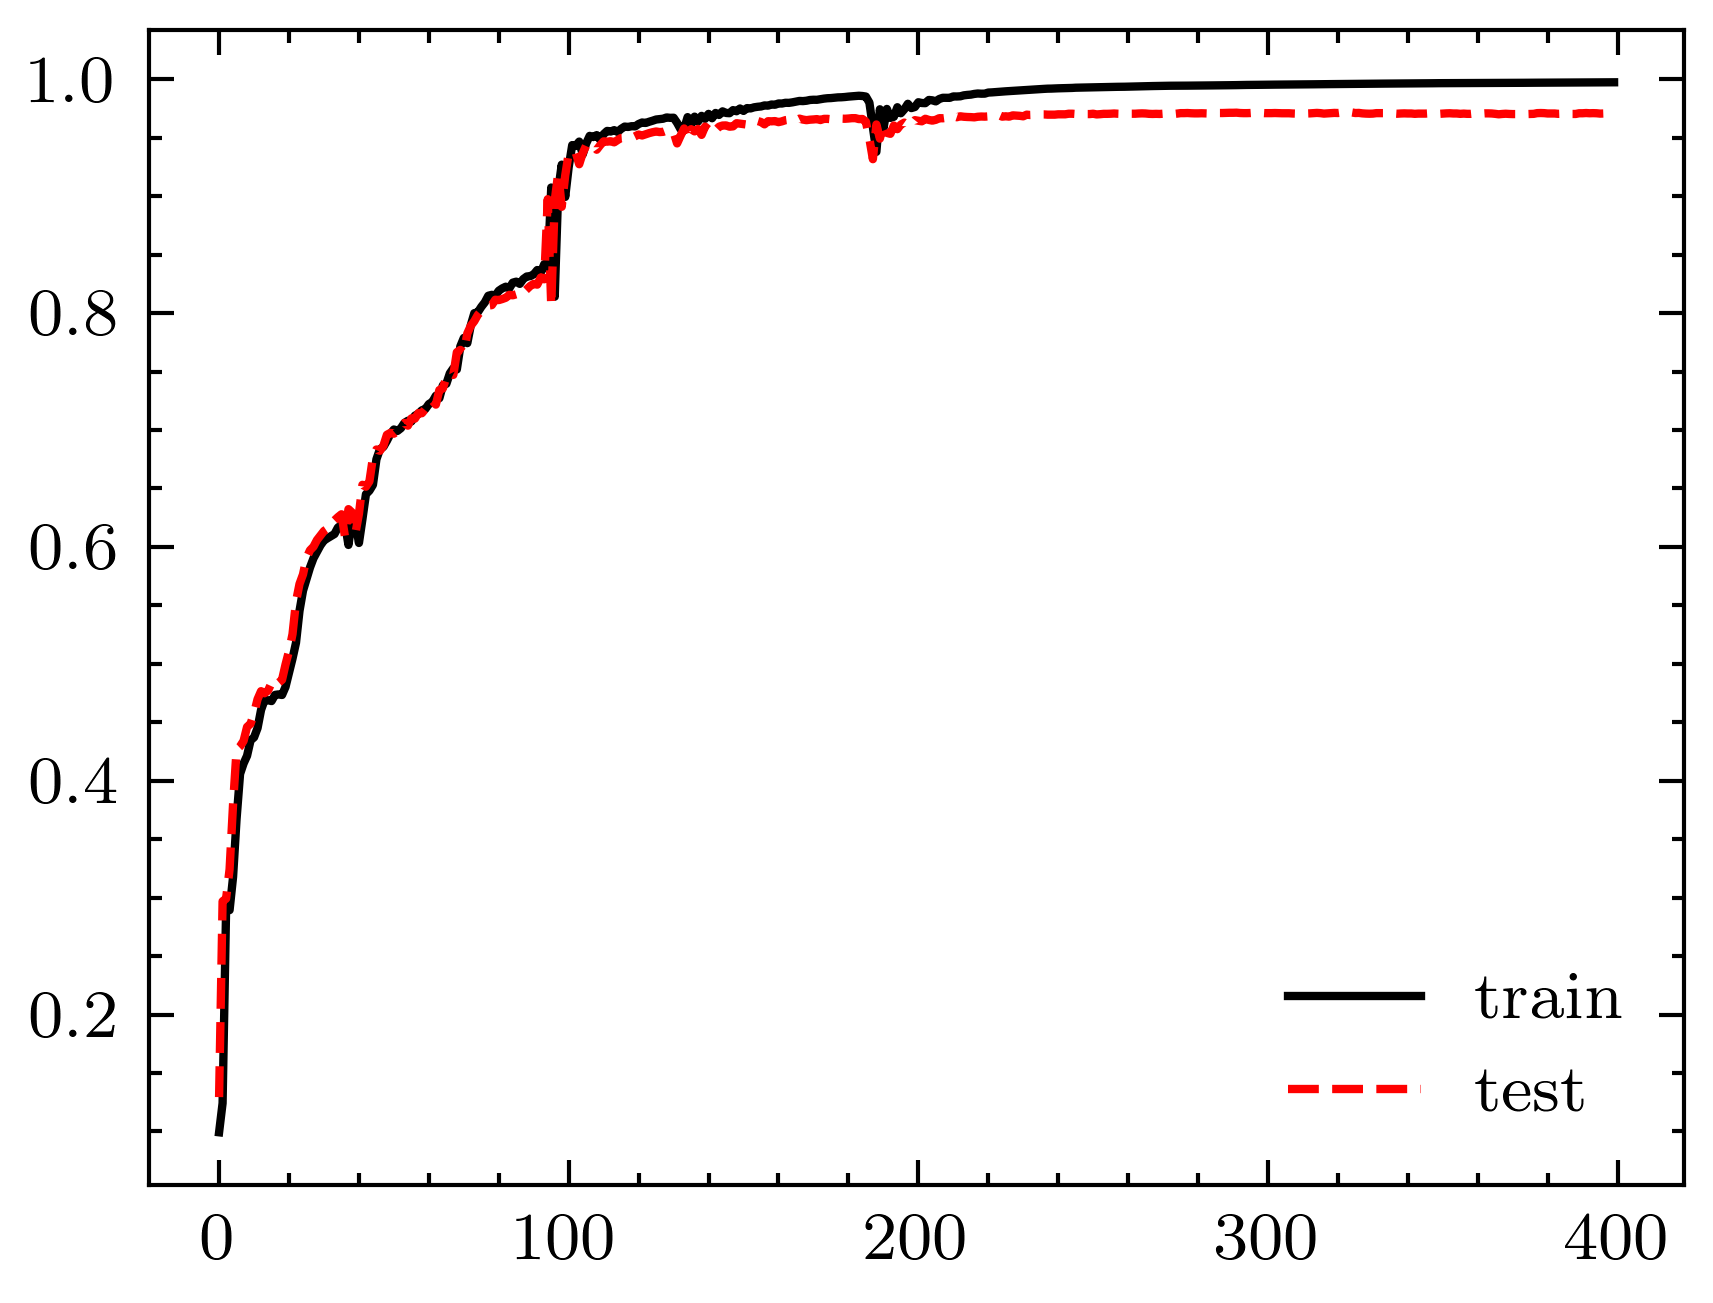

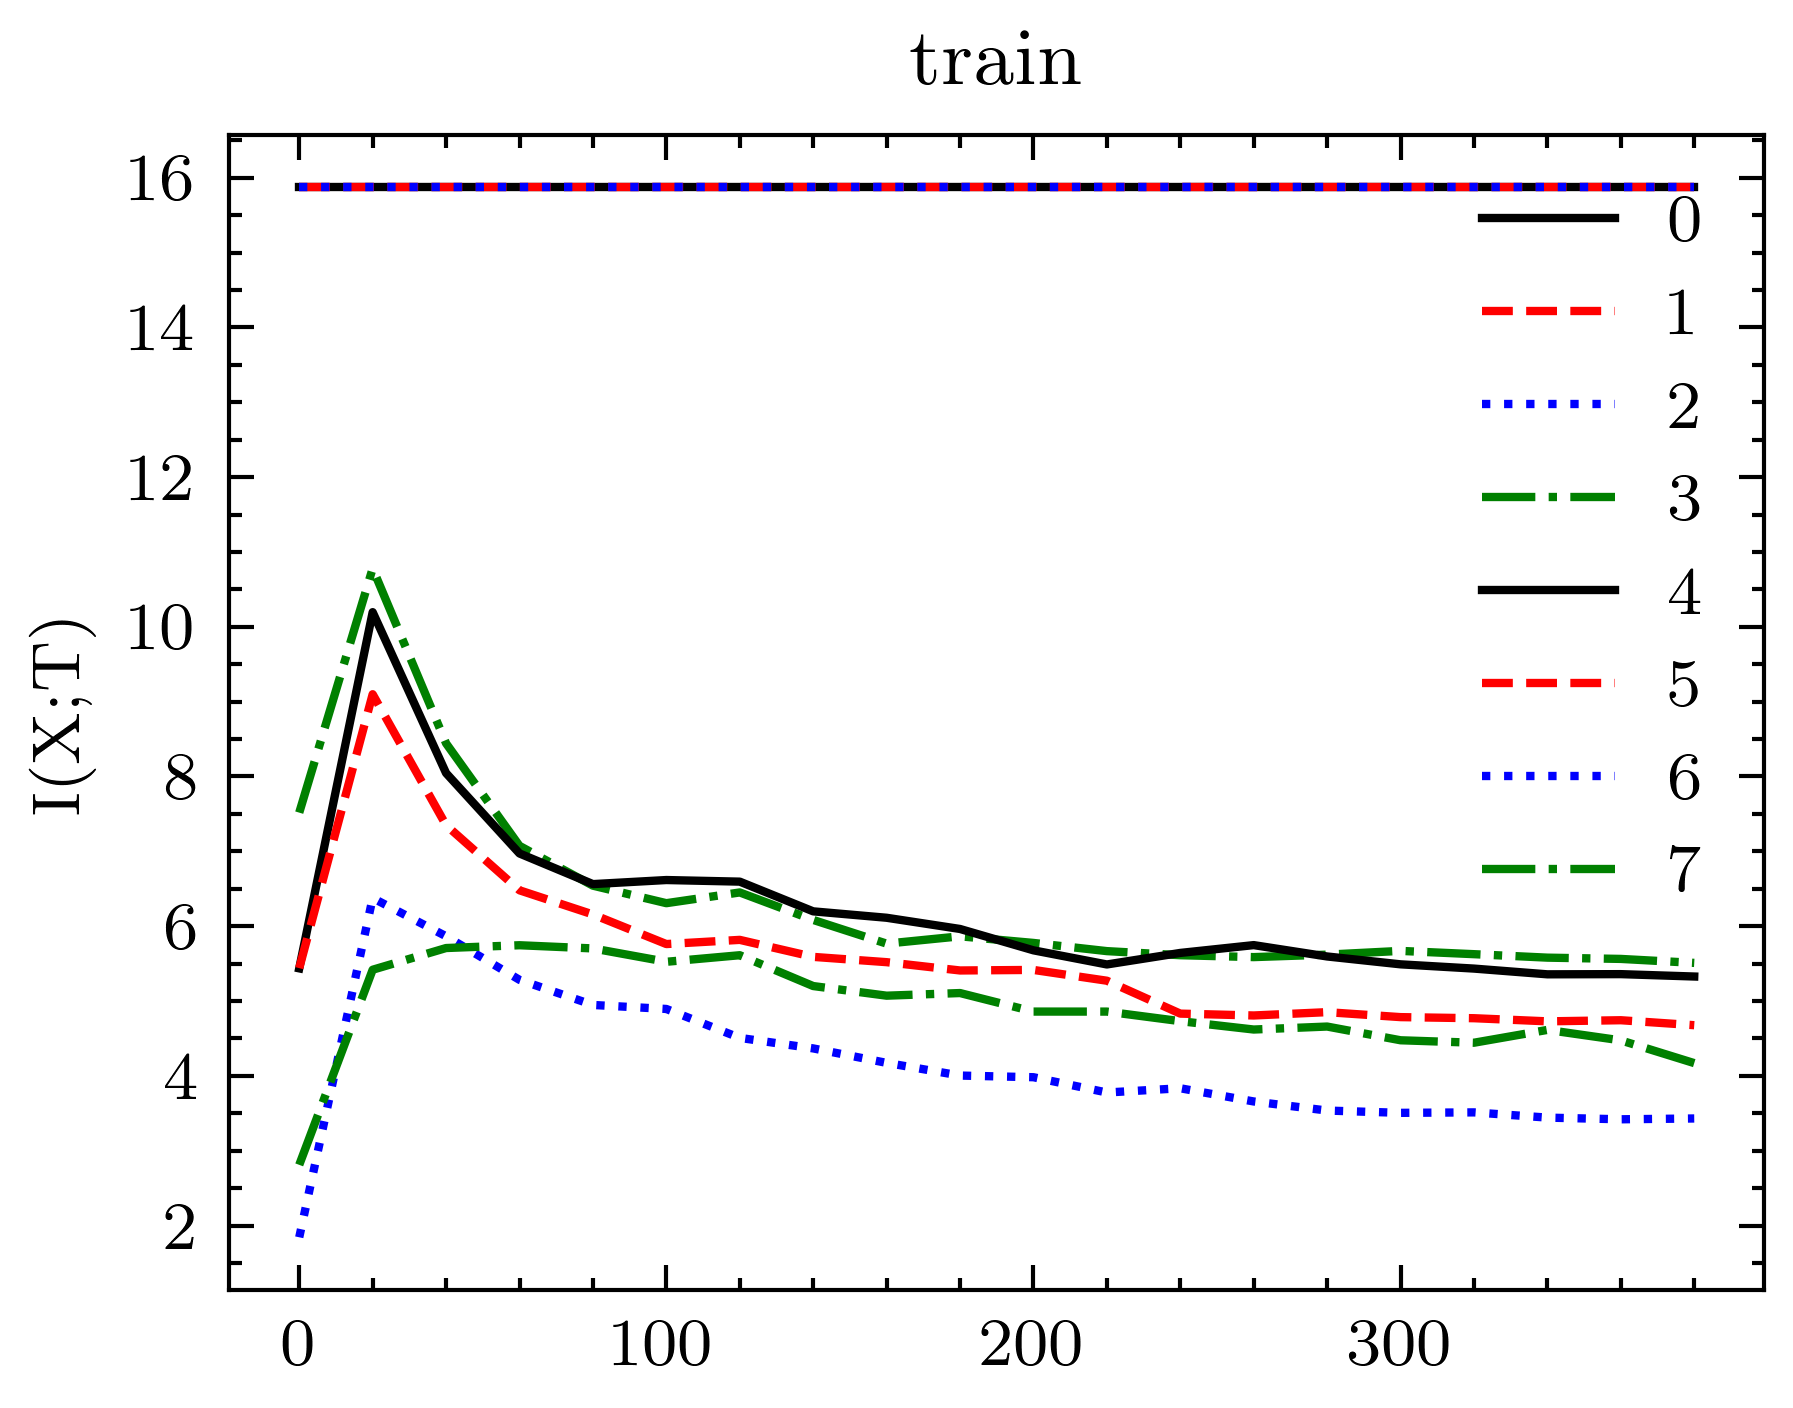

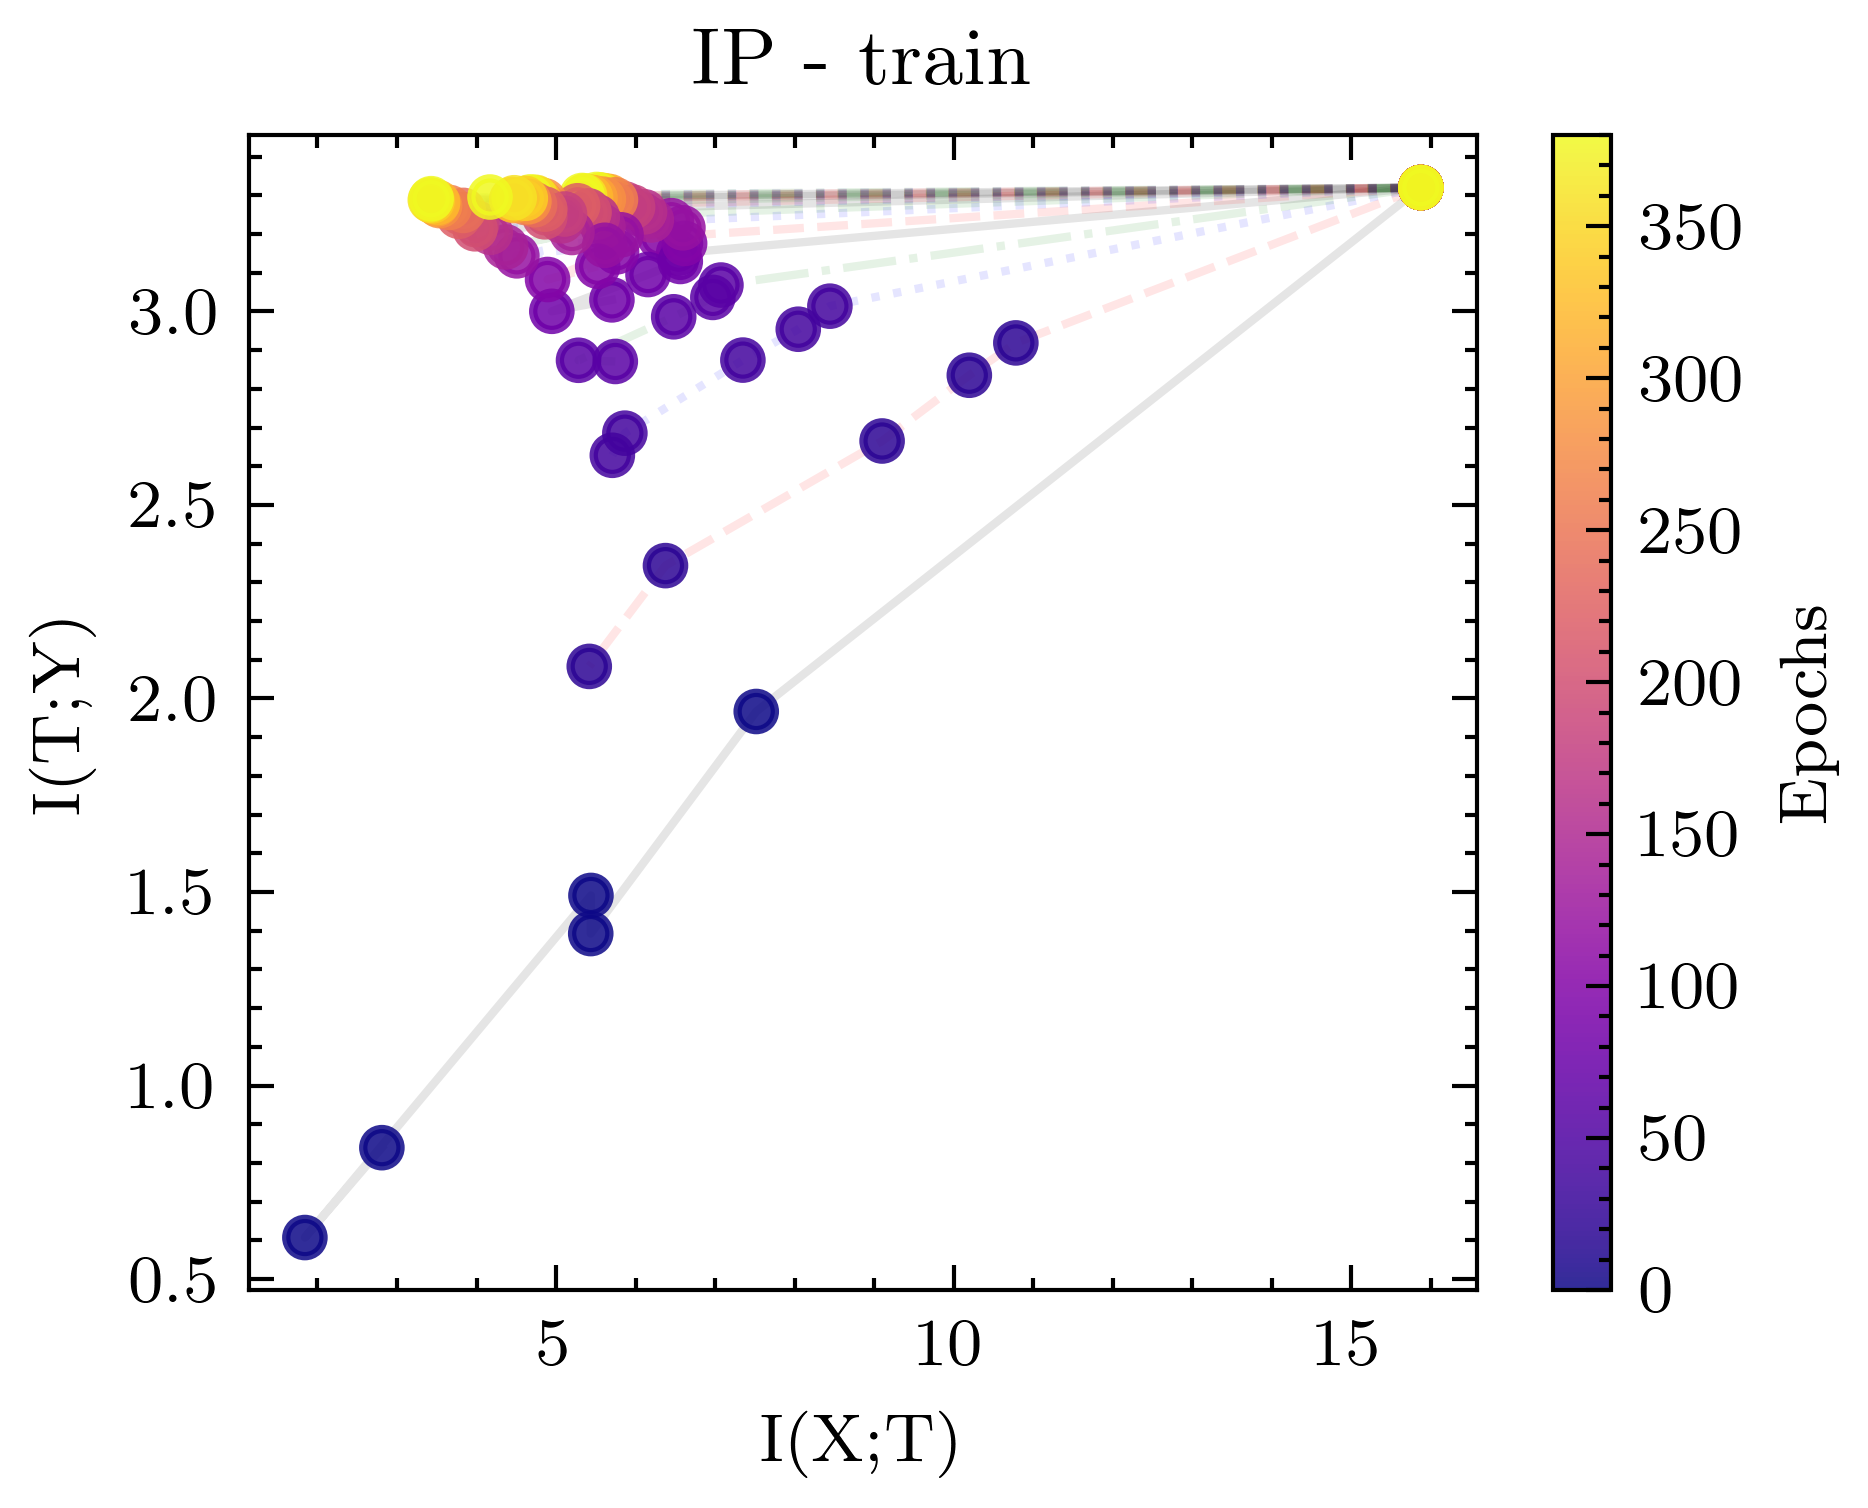

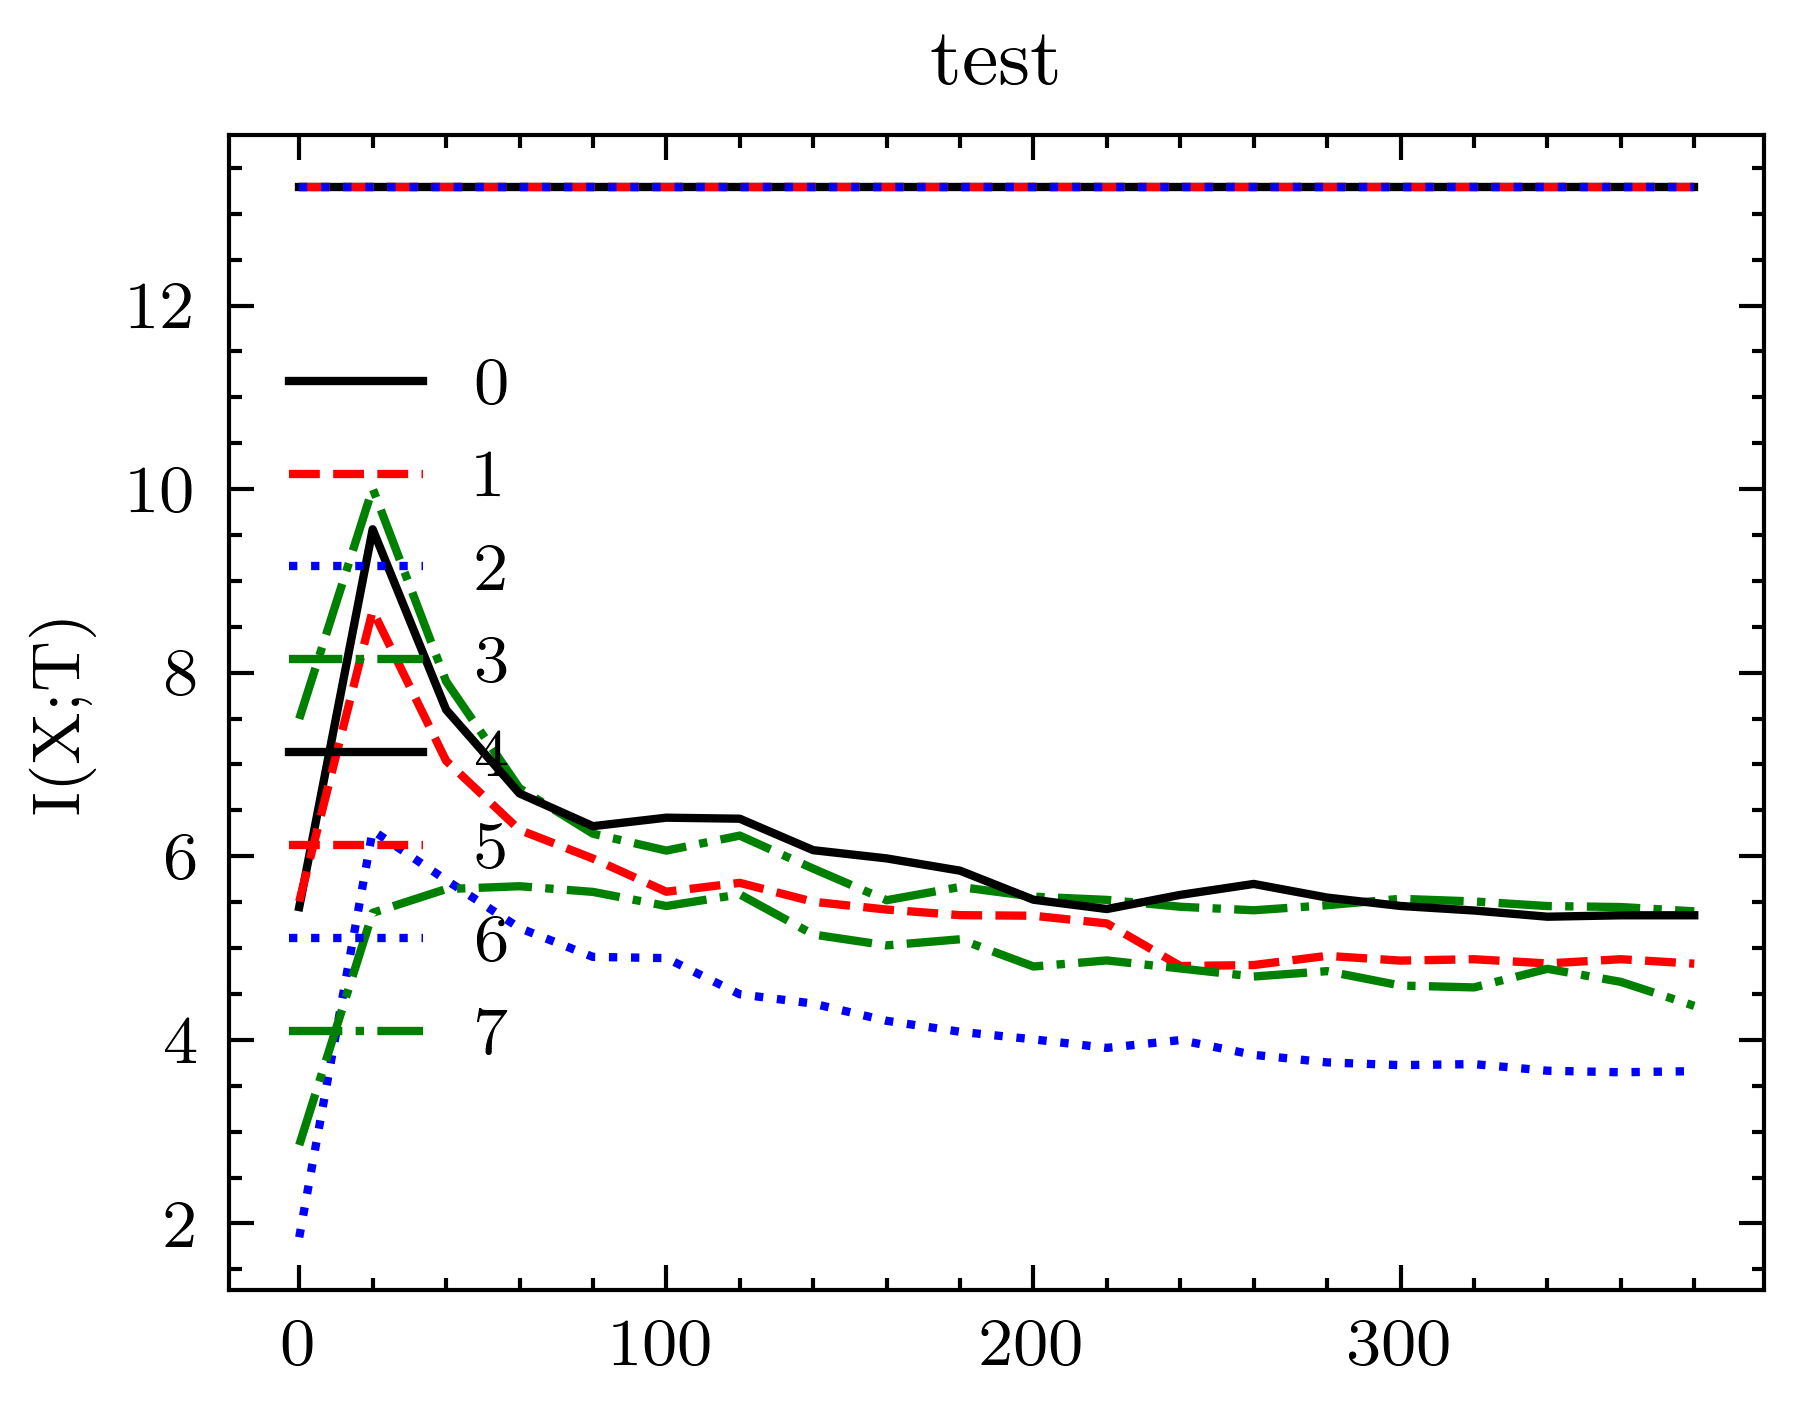

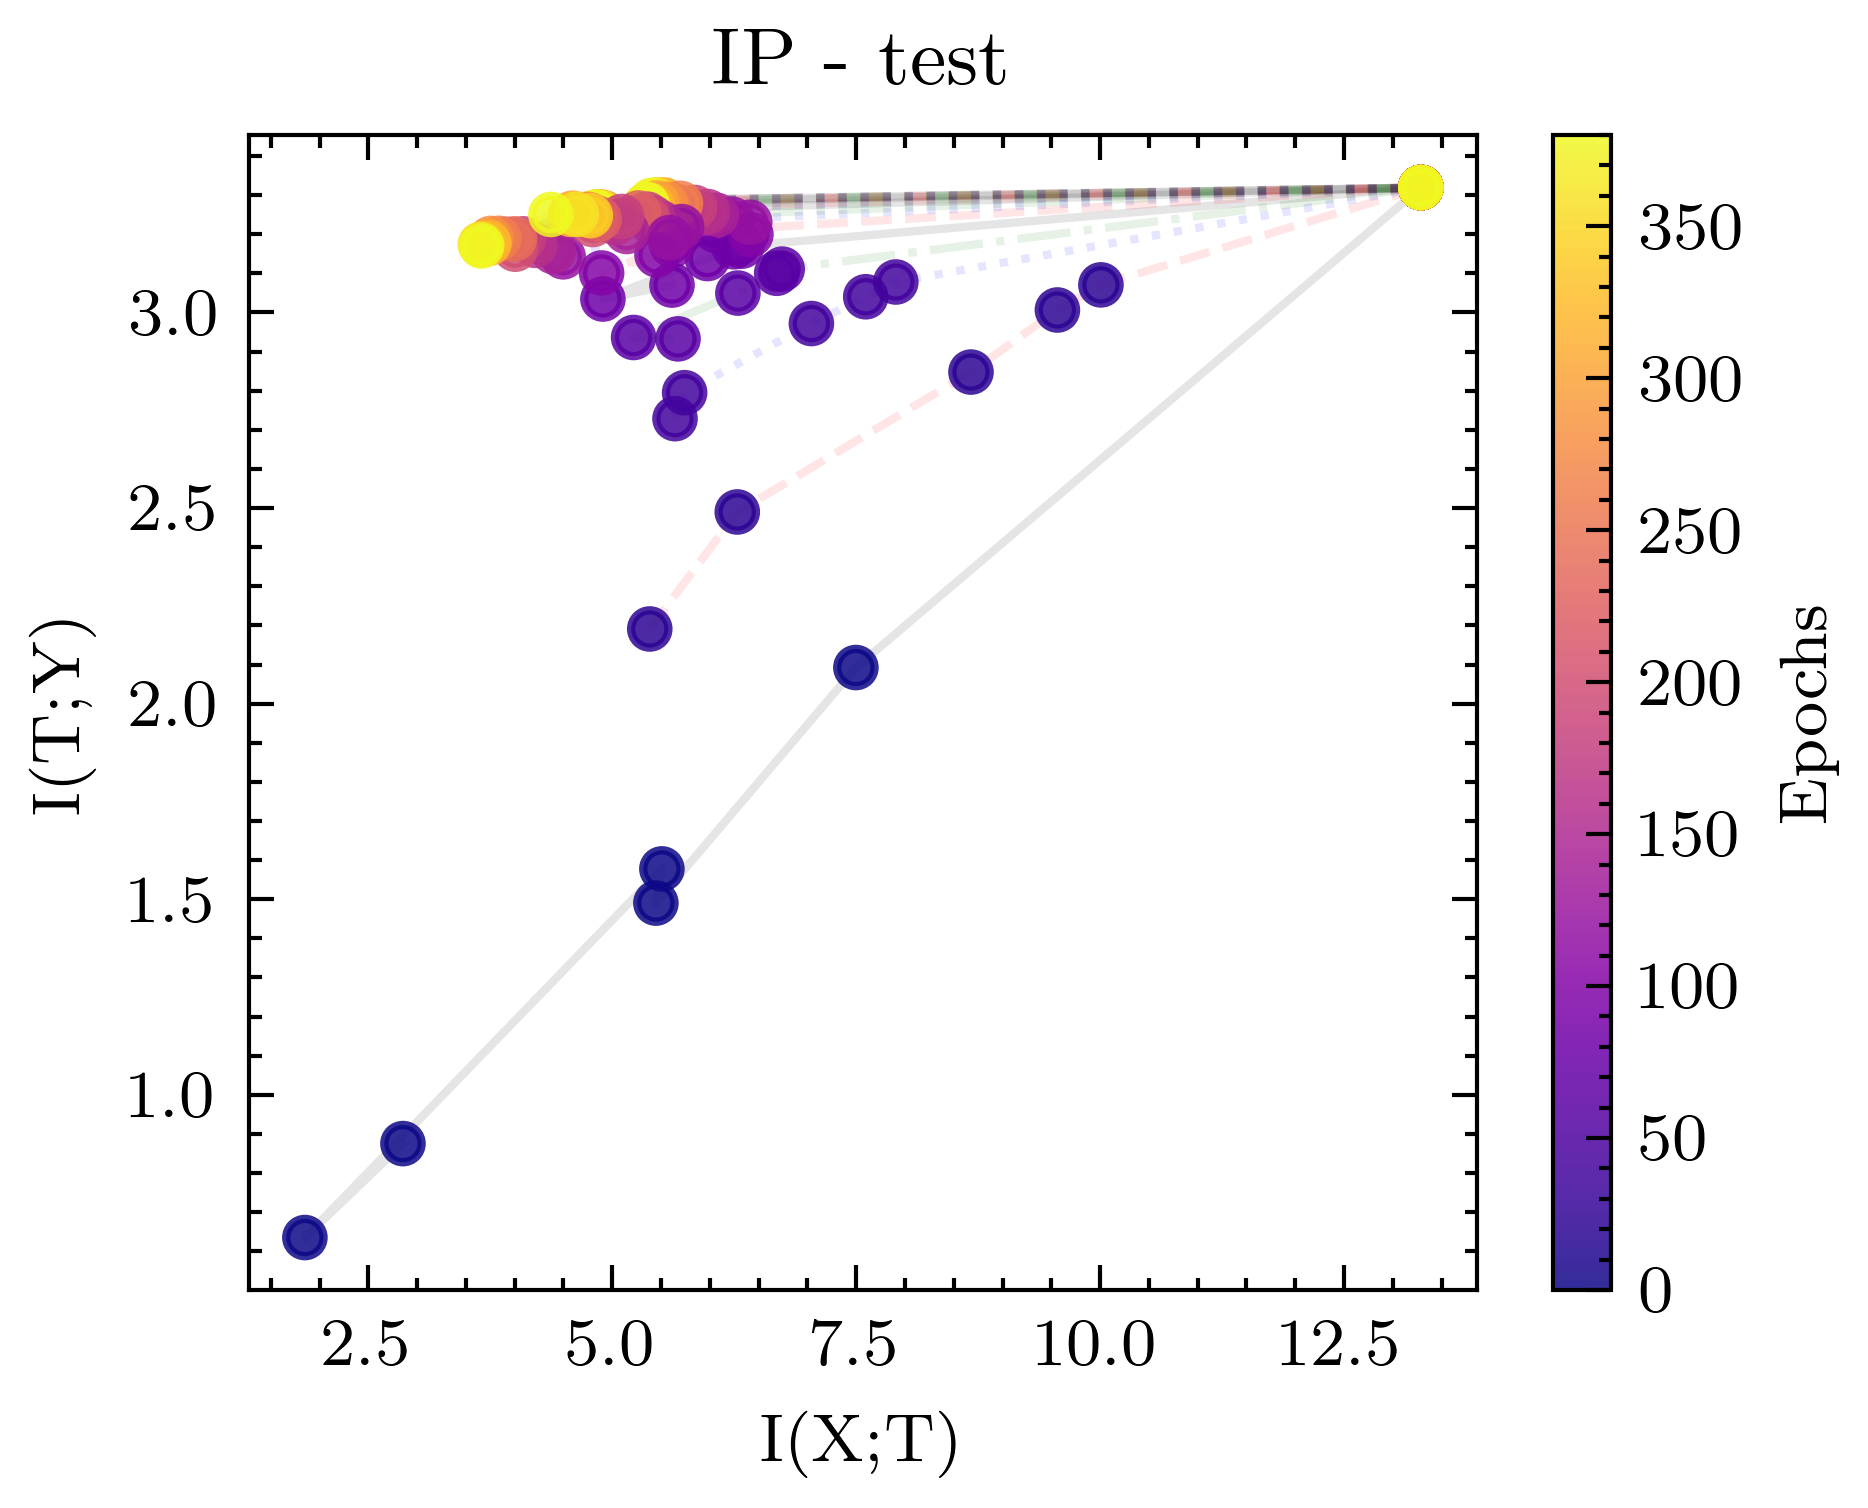

In [29]:
plot = Plotter(train)
plot.plot_losses()
plot.plot_accuracy()
plot.plot_info_plan('train')
plot.plot_info_plan('test')